In [1]:
# Ensure you have the correct packages installed
!pip install keras==2.12.0
!pip install tensorflow
!pip install scikeras==0.10.0  # Ensure scikeras is installed
!pip install scikit-learn==1.2.2  # Ensure sklearn is compatible

# Imports
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import losses, optimizers, layers, regularizers, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier  # Use the correct KerasClassifier from scikeras


  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires keras>=3.0.0, but you have keras 2.12.0 which is incompatible.
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0


In [2]:
# Step 1: Prepare the dataset
# Get image data
os.makedirs('body_score_dataset', exist_ok=True)
!git clone -b body_scores_prediction_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./body_score_dataset 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


fatal: destination path './body_score_dataset' already exists and is not an empty directory.


In [3]:
# Load label data
df_train_data = pd.read_csv('/kaggle/working/body_score_dataset/train_data.csv')

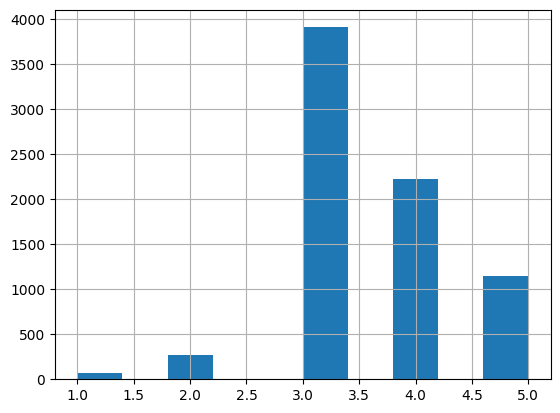

In [4]:
# Display the distribution of body scores
df_train_data['bodyScore'].hist()
plt.show()

In [5]:
# Get file path for image files
df_train_data['filepath'] = df_train_data.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)

In [6]:
# Create array of body scores and file paths
body_scores = df_train_data.bodyScore.values
file_paths = df_train_data.filepath.values

In [7]:
# Load image and body_score, apply preprocessing to image
def load_and_preprocess_image(file_path, body_score=None):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224]) 
    image = tf.cast(image, tf.float32) / 255.0 
    if body_score is not None:
        return image, body_score
    else:
        return image

In [8]:
# Data Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [9]:
# Step 2: Implement Cross-Validation
# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [10]:
# Store validation scores
val_scores = []

In [11]:
# Loop over each fold
for train_index, val_index in kf.split(file_paths):
    # Split the data
    train_file_paths, val_file_paths = file_paths[train_index], file_paths[val_index]
    train_body_scores, val_body_scores = body_scores[train_index], body_scores[val_index]
    
    # Create TensorFlow datasets for training and validation
    train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_body_scores))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_body_scores))
    
    train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=2000).batch(32)
    
    val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(32)

In [12]:
    # Re-initialize the model for each fold
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        pooling='avg',
    )
    
    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(units=1, activation='relu')
    ])
    
    model.compile(
        loss=losses.MeanSquaredError(),
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['mae', 'mse']
    )

In [13]:
  # Train the model
model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=25,
        batch_size=32,
        verbose=1
    )

Epoch 1/25


I0000 00:00:1724697636.114569    1345 service.cc:145] XLA service 0x7bbd8c120560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724697636.114622    1345 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724697636.114628    1345 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724697693.330930    1345 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 188s 474ms/step - loss: 5.4278 - mae: 1.5274 - mse: 3.8866 - val_loss: 12.9256 - val_mae: 3.2726 - val_mse: 11.3989
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 2.4606 - mae: 0.7688 - mse: 0.9398 - val_loss: 9.3708 - val_mae: 2.6460 - val_mse: 7.8685
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - loss: 2.2657 - mae: 0.6964 - mse: 0.7700 - val_loss: 2.9003 - val_mae: 0.9002 - val_mse: 1.4247
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - loss: 2.1864 - mae: 0.6678 - mse: 0.7179 - val_loss: 2.3847 - val_mae: 0.7320 - val_mse: 0.9376
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 147ms/step - loss: 2.0827 - mae: 0.6301 - mse: 0.6429 - val_loss: 2.0399 - val_mae: 0.6095 - val_mse: 0.6224
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - loss: 2.0285 - mae: 0.6192 - mse: 0.6186 - val_loss: 1.9240 - val_mae: 0.5767 - val_mse: 0.5372
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - loss: 1.9372 - mae: 0.5862 - mse:

In [14]:
# Evaluate the model on validation data
val_loss = model.evaluate(val_dataset)
val_scores.append(val_loss)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.2390 - mae: 0.5475 - mse: 0.4711


In [15]:
# Calculate the average validation loss across folds
avg_val_loss = np.mean(val_scores)
print(f"Average Validation Loss across {k} folds: {avg_val_loss}")

Average Validation Loss across 5 folds: 0.7557327449321747


In [16]:
# Step 3: Hyperparameter Tuning with GridSearchCV
# Function to create the model (for hyperparameter tuning)
def create_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        pooling='avg',
    )
    
    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(dropout_rate),
        layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(dropout_rate),
        layers.Dense(units=1, activation='relu')
    ])
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss=losses.MeanSquaredError(),
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )
    return model

In [17]:
# Wrap the model using KerasClassifier from scikeras
model = KerasClassifier(model=create_model, epochs=20, batch_size=32, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.0001],
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64]
}

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_image(filepath, target_size=(224, 224)):
    """Loads and preprocesses an image."""
    img = load_img(filepath, target_size=target_size)  # Load the image
    img_array = img_to_array(img)  # Convert the image to array
    img_array = preprocess_input(img_array)  # Preprocess the image
    return img_array

# Load and preprocess all images
X = np.array([load_and_preprocess_image(fp) for fp in file_paths])


In [19]:
# Example of a model-creating function
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(EfficientNetB0(input_shape=(224, 224, 3), include_top=False, pooling='avg'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='linear'))  # Assuming this is a regression problem
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [20]:
# Wrap your model in KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

In [40]:
# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.0001],
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Replace GridSearchCV with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3, random_state=42)
random_search_result = random_search.fit(X, body_scores)

# After fitting, you can access the best parameters and score
print(f"Best params: {random_search_result.best_params_}, Best score: {random_search_result.best_score_}")

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [23]:
# Train the final model
final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 155s 402ms/step - loss: 2.0580 - val_loss: 3.8208
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 144ms/step - loss: 0.6509 - val_loss: 1.6588
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.5358 - val_loss: 1.9004
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - loss: 0.4637 - val_loss: 0.6964
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - loss: 0.4257 - val_loss: 0.5762
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.3591 - val_loss: 0.5482
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 147ms/step - loss: 0.3331 - val_loss: 0.5022
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - loss: 0.3110 - val_loss: 0.5281
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.2710 - val_loss: 0.5345
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.2707 - val_loss: 0.4927
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.2351 - val_loss: 0.4613
Epoch 12/20
191/19

In [24]:
# Step 5: Prepare test dataset and make predictions
# Load submission file
df_submit = pd.read_csv('/kaggle/working/body_score_dataset/sample_submission.csv')

In [28]:
print(df_submit_file_paths)  # Check the format of the file paths


['body_score_dataset/0004/b909623b-39b0-47e7-ba71-356d74d3f2cb5779846075273803342_jpg.rf.4bfd54824e7f76199d0d0826c715b16e.jpg'
 'body_score_dataset/0003/8dc92b10-e198-4bad-a413-2cea6ef30e8c3040278561446288282_jpg.rf.841baaa7de9b931d2cf74c596dad53a3.jpg'
 'body_score_dataset/0003/605f77a6-58e2-4d53-9821-cc9f760617f89211689386221365508_jpg.rf.36a4b175ea5ea8bf0861fc2e108cef28.jpg'
 ...
 'body_score_dataset/0005/d4f77a0c-c496-4de2-add4-847c4e778d697833015776453501111_jpg.rf.6a464d5343a008848b497fd2630277d1.jpg'
 'body_score_dataset/0004/b016cf03-76cc-4869-bb94-e12d7b02c0353470259687987506268_jpg.rf.f294b820d0cbffc393cd6a4b629d711d.jpg'
 'body_score_dataset/0005/ea052d3f-d9b4-4018-8bd3-b3e77f0793127257232590231225414_jpg.rf.3068e118e55fbec924585390a6fa90f7.jpg']


In [30]:
# A wrapper function for using `map` with TensorFlow's dataset API
def tf_load_and_preprocess_image(file_path):
    return tf.py_function(load_and_preprocess_image, [file_path], tf.float32)

In [35]:
# Load image and preprocess it
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224]) 
    image = tf.cast(image, tf.float32) / 255.0 
    return image

# Wrapper function for TensorFlow Dataset API
def tf_load_and_preprocess_image(file_path):
    # Convert the path to a string and apply preprocessing
    return tf.py_function(func=load_and_preprocess_image, inp=[file_path], Tout=tf.float32)


In [36]:
# Prepare test dataset
df_submit = pd.read_csv('/kaggle/working/body_score_dataset/sample_submission.csv')
df_submit['filepath'] = df_submit.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)
df_submit_file_paths = df_submit.filepath.values

# Create a dataset from the file paths
test_dataset = tf.data.Dataset.from_tensor_slices(df_submit_file_paths)
test_dataset = test_dataset.map(tf_load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)  # Use the same batch_size

# Ensure that the dataset returns batches of images, not file paths
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [37]:
# Make predictions
predictions = final_model.predict(test_dataset)
predictions_flattened = predictions.flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step


In [38]:
# Cap the predictions at 5.0
df_submit['bodyScore'] = [5.0 if i > 5 else i for i in predictions_flattened]

In [39]:
# Save the submission file
df_submit[['filename', 'bodyScore']].to_csv('submission3.csv', index=False)

print("Submission file saved as 'submission3.csv'.")

Submission file saved as 'submission3.csv'.
